<a href="https://colab.research.google.com/github/jwjang1/Gold-Price-Prediction/blob/main/Gold_Price_Prerdiction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import kagglehub
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping

import warnings
from warnings import filterwarnings
warnings.simplefilter(action='ignore')
%matplotlib inline

In [7]:
# 데이터 다운로드 및 로딩

# 최신 데이터 다운로드
path = kagglehub.dataset_download("nisargchodavadiya/daily-gold-price-20152021-time-series")
file_name = "Gold Price.csv"
file_path = os.path.join(path, file_name)

data = pd.read_csv(file_path)

print(data.head())

100%|██████████| 46.6k/46.6k [00:00<00:00, 42.5MB/s]

Extracting files...
         Date  Price   Open   High    Low  Volume  Chg%
0  2024-11-06  77030  78300  78570  77030       0 -1.86
1  2024-11-05  78490  78224  78670  78160       0  0.11
2  2024-11-04  78401  78498  78642  78237       0 -0.54
3  2024-11-01  78829  78650  78887  78550       0  0.64
4  2024-10-31  78326  79264  79999  77803      90 -1.17


In [8]:
df = pd.DataFrame(data)
df1 = df.copy()
df

,Date,Price,Open,High,Low,Volume,Chg%
0,2024-11-06,77030,78300,78570,77030,0,-1.86
1,2024-11-05,78490,78224,78670,78160,0,0.11
2,2024-11-04,78401,78498,78642,78237,0,-0.54
3,2024-11-01,78829,78650,78887,78550,0,0.64
4,2024-10-31,78326,79264,79999,77803,90,-1.17
...,...,...,...,...,...,...,...
2801,2014-01-06,29119,29300,29395,29051,24380,-0.55
2802,2014-01-04,29279,29279,29279,29279,0,-1.51
2803,2014-01-03,29727,30031,30125,29539,3050,-0.83
2804,2014-01-02,29975,29678,30050,29678,3140,1.47


In [10]:
df.describe()

,Price,Open,High,Low,Volume,Chg%
count,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000
mean,40699.885959,40700.218460,40917.777976,40482.312901,12529.581611,0.037758
std,13828.621023,13826.938709,13900.465881,13756.094789,10649.994389,0.828591
min,24545.000000,24583.000000,24635.000000,24470.000000,0.000000,-5.980000
25%,29128.000000,29103.750000,29261.250000,28974.000000,6282.500000,-0.380000
50%,32980.000000,33000.000000,33220.500000,32890.000000,10770.000000,0.040000
75%,50613.500000,50646.750000,50911.250000,50337.500000,16397.500000,0.450000
max,79257.000000,79264.000000,79999.000000,78888.000000,106920.000000,5.300000


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,2806.0,40699.885959,13828.621023,24545.00,29128.00,32980.00,50613.50,79257.0
Open,2806.0,40700.218460,13826.938709,24583.00,29103.75,33000.00,50646.75,79264.0
High,2806.0,40917.777976,13900.465881,24635.00,29261.25,33220.50,50911.25,79999.0
Low,2806.0,40482.312901,13756.094789,24470.00,28974.00,32890.00,50337.50,78888.0
Volume,2806.0,12529.581611,10649.994389,0.00,6282.50,10770.00,16397.50,106920.0
Chg%,2806.0,0.037758,0.828591,-5.98,-0.38,0.04,0.45,5.3


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2806 entries, 0 to 2805
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2806 non-null   object 
 1   Price   2806 non-null   int64  
 2   Open    2806 non-null   int64  
 3   High    2806 non-null   int64  
 4   Low     2806 non-null   int64  
 5   Volume  2806 non-null   int64  
 6   Chg%    2806 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 153.6+ KB


In [13]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Chg%'], dtype='object')

In [14]:
df['Date']= pd.to_datetime(df['Date'])
df = df.set_index('Date')
df

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2024-11-06,77030,78300,78570,77030,0,-1.86
2024-11-05,78490,78224,78670,78160,0,0.11
2024-11-04,78401,78498,78642,78237,0,-0.54
2024-11-01,78829,78650,78887,78550,0,0.64
2024-10-31,78326,79264,79999,77803,90,-1.17
...,...,...,...,...,...,...
2014-01-06,29119,29300,29395,29051,24380,-0.55
2014-01-04,29279,29279,29279,29279,0,-1.51
2014-01-03,29727,30031,30125,29539,3050,-0.83


EDA

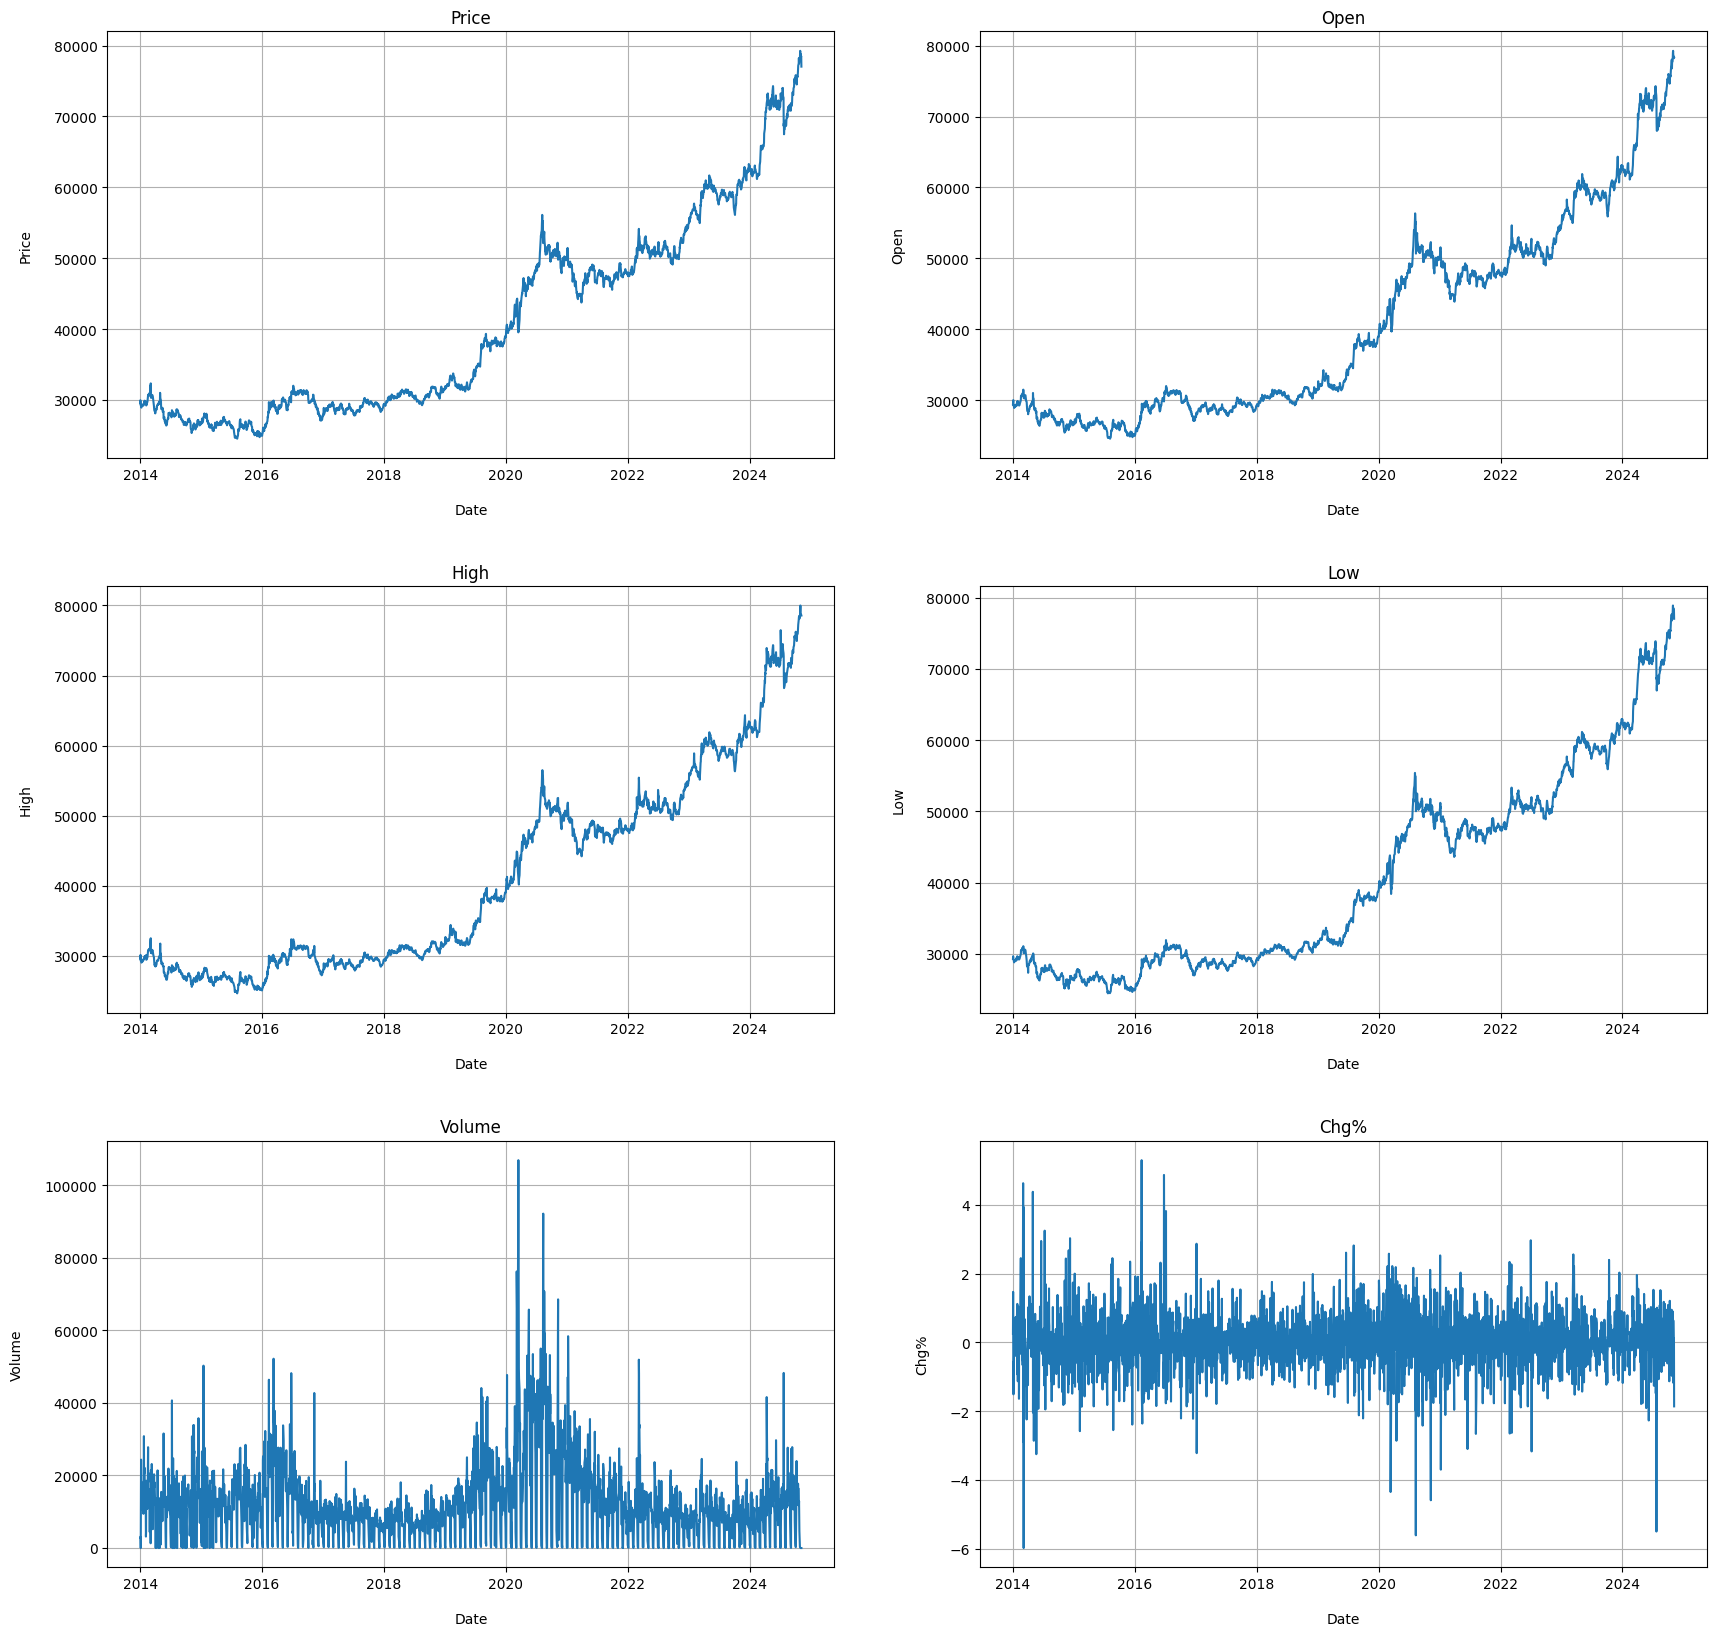

In [25]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(40)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)

i=1
for column in df.columns:
    plt.subplot(6,2,i)
    plt.plot(df[column])
    plt.title(column)
    # plt.xticks(fontsize=13)
    # plt.yticks(fontsize=13)
    plt.xlabel('Date',labelpad=15)
    plt.ylabel(column,labelpad=15)
    plt.grid()
    i+=1